# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import pathlib
import PIL
import os
import time
from glob import glob

from PIL import Image as PImage
from PIL import ImageFilter
import random
import math

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


AUTOTUNE = tf.data.AUTOTUNE


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Creating the data pipeline


Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

first parameters for loading

In [4]:
batch_size = 512 
img_height = 64
img_width = 64
epochs = 100

validation = 0.2

data_dir = 'Data/characters/'

Split the data into 80% training and 20% testing

In [5]:
from glob import glob
import random

def make_dataset(path, batch_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [img_height, img_width])
    return image

  def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    #ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  dataset_size = len(filenames)
  random.shuffle(filenames)
  labels = [classes.index(name.split(os.path.sep)[-2]) for name in filenames]

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds, classes, dataset_size

In [6]:
dataset, class_names, dataset_size = make_dataset(data_dir, batch_size)

val_size = int(validation * dataset_size / batch_size)

print(f'Size: {dataset_size}, val: {val_size * batch_size}')


val_ds = dataset.take(val_size)

train_ds = dataset.skip(val_size)

train_size = dataset_size - val_size

#train_ds = train_ds.map()

# PRINT VALIDATION HERE

ValueError: '某' is not in list

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(16, 16))
i = 0

while i < 25:
    ax = plt.subplot(5, 5, i + 1)
    #plt.imshow(aug[i].numpy().astype("uint8"))
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'L: {class_names[label]}')
    plt.axis("off")
    i += 1


NameError: name 'train_ds' is not defined

# Train the model

## Set up model

structures from [2]

In [7]:
from models import *

model = get_M16(len(class_names))

#can't have here with the resize layer
#model.summary()

In [8]:
model_dir = 'D:\\MachineLearning\\models'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.ckpt")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [9]:
sched = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 5 * train_size ,
    decay_rate = 0.9,
    staircase = True,
)


optimizer = tf.keras.optimizers.Adam(learning_rate=sched,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-8,
                                #clipvalue=1,
                                )
                                
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [10]:
#model = tf.keras.models.load_model(os.path.join(model_dir, "tf", "trained_model"))
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-30-0.20.hdf5"))

In [11]:
history = model.fit(
    x=train_ds,
    epochs=epochs,
    initial_epoch=0,
    validation_data=val_ds,
    callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=4)

MachineLearning\models\tf\checkpoints\weights-improvement-22-0.81.ckpt\assets
Epoch 23/100
954/954 [==============================] - 331s 347ms/step - loss: 0.1994 - accuracy: 0.7901 - val_loss: 0.1024 - val_accuracy: 0.8132

Epoch 00023: val_accuracy improved from 0.81275 to 0.81321, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-23-0.81.ckpt
INFO:tensorflow:Assets written to: D:\MachineLearning\models\tf\checkpoints\weights-improvement-23-0.81.ckpt\assets
Epoch 24/100
954/954 [==============================] - 331s 346ms/step - loss: 0.1873 - accuracy: 0.7933 - val_loss: 0.1082 - val_accuracy: 0.8117

Epoch 00024: val_accuracy did not improve from 0.81321
Epoch 25/100
954/954 [==============================] - 331s 347ms/step - loss: 0.1765 - accuracy: 0.7960 - val_loss: 0.1008 - val_accuracy: 0.8138

Epoch 00025: val_accuracy improved from 0.81321 to 0.81385, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-25-0.81.ckpt
INFO

238/238 - 23s - loss: 0.0430 - accuracy: 0.8273
0.8273125886917114


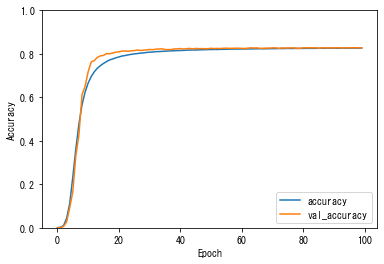

In [12]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [13]:
#model.save(os.path.join(model_dir, "tf", "trained_model"))

In [14]:
model.summary()

Model: "M16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 1)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 64, 64, 1)         0         
_________________________________________________________________
random_translation (RandomTr (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0       

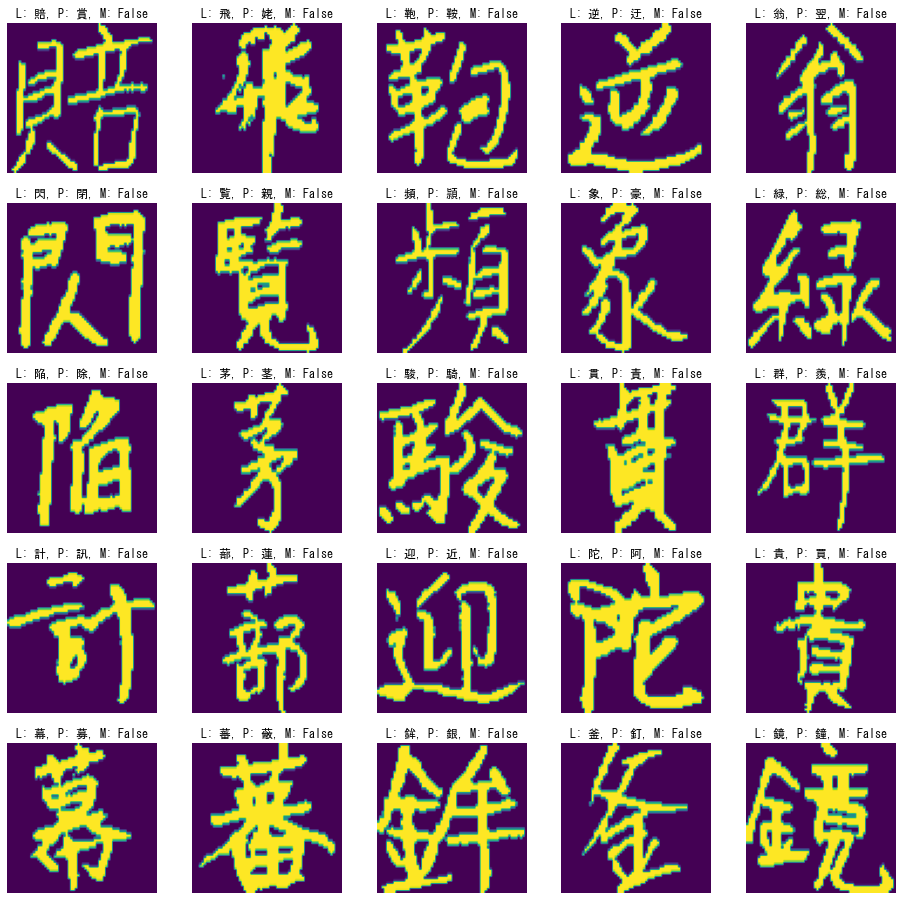

In [15]:
image_batch, label_batch = next(iter(val_ds))
p = model.predict(image_batch)
p = p.argmax(axis=1)


plt.figure(figsize=(16, 16))
i = 0
j = 0
while i < 25:
  if class_names[label_batch[j]] != class_names[p[j]]:
    ax = plt.subplot(5, 5, i + 1)
    #plt.imshow(aug[i].numpy().astype("uint8"))
    plt.imshow(image_batch[j].numpy().astype("uint8"))
    label = label_batch[j]
    plt.title(f'L: {class_names[label]}, P: {class_names[p[j]]}, M: {class_names[label] == class_names[p[j]]}')
    plt.axis("off")
    i+= 1

  j+=1

In [16]:
test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

238/238 - 23s - loss: 0.0428 - accuracy: 0.8273
